# Final Project, CSC 481
Eric Vistnes

In [620]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import pickle
import os
import random
import cv2

## The Data

In [523]:
imagePaths = list(paths.list_images("Dataset"))
images = []
classes = []

In [524]:
images = []
classes = []
for path in imagePaths:
    try:
        image = cv2.imread(path)
        image = cv2.resize(image, (64, 64))
        images.append(image)
        
        classes.append(path.split(os.path.sep)[1])
    except:
        #print("Bad Filepath: ", path)
        i = 0


In [525]:
images = np.array(images, dtype="float") / 255.0
classes = np.array(classes)

In [665]:
classes

array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
       'without_mask', 'without_mask'], dtype='<U12')

In [667]:
images[np.where(classes == "without_mask")].shape[0]

5521

In [526]:
np.save("images", images)
np.save("classes", classes)

In [553]:
(trainX, testX, trainY, testY) = train_test_split(images, classes, test_size=.2, random_state=42)

In [559]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [563]:
lb = LabelBinarizer()
lb.fit(trainY)
trainY = to_categorical(lb.transform(trainY), 2)
testY = to_categorical(lb.transform(testY), 2)

In [564]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Training Classifier

model = Sequential()
model.add(Dense(1024, input_shape=(3072,), activation="sigmoid"))
model.add(Dense(512, activation="sigmoid"))
model.add(Dense(2, activation="sigmoid"))

opt = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

H = model.fit(x=trainX, y=trainY, validation_data=(testX, testY), epochs=80, batch_size=32)

model.save("Model1", save_format="h5")
f = open("Labels1", "wb")
f.write(pickle.dumps(lb))
f.close()

# Train CNN

In [555]:
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        #first layer set
        model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        #second layer set
        model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        #third layer set
        model.add(Conv2D(128, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3,3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        #fourth layer set
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(2))
        model.add(Activation("softmax"))
        
        return model

In [565]:
model2 = SmallVGGNet.build(width=64, height=64, depth=3, classes=2)

In [566]:
INIT_LR = 0.01
EPOCHS = 75
BS = 32
# initialize the model and optimizer (you'll want to use
# binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the network
H = model2.fit(x=aug.flow(trainX, trainY, batch_size=BS), 
validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS)

[INFO] training network...
Epoch 1/75
276/276 [==============================] - 103s 372ms/step - loss: 0.4435 - accuracy: 0.8478 - val_loss: 1.2368 - val_accuracy: 0.5097
Epoch 2/75
276/276 [==============================] - 99s 357ms/step - loss: 0.2550 - accuracy: 0.9131 - val_loss: 0.1996 - val_accuracy: 0.9249
Epoch 3/75
276/276 [==============================] - 96s 346ms/step - loss: 0.2027 - accuracy: 0.9302 - val_loss: 0.3919 - val_accuracy: 0.8637
Epoch 4/75
276/276 [==============================] - 97s 350ms/step - loss: 0.1835 - accuracy: 0.9352 - val_loss: 0.1062 - val_accuracy: 0.9638
Epoch 5/75
276/276 [==============================] - 96s 348ms/step - loss: 0.1771 - accuracy: 0.9406 - val_loss: 0.0961 - val_accuracy: 0.9706
Epoch 6/75
276/276 [==============================] - 96s 349ms/step - loss: 0.1473 - accuracy: 0.9479 - val_loss: 0.0917 - val_accuracy: 0.9710
Epoch 7/75
276/276 [==============================] - 96s 349ms/step - loss: 0.1518 - accuracy: 0.9460

Epoch 57/75
276/276 [==============================] - 94s 342ms/step - loss: 0.0577 - accuracy: 0.9799 - val_loss: 0.1145 - val_accuracy: 0.9538
Epoch 58/75
276/276 [==============================] - 98s 355ms/step - loss: 0.0489 - accuracy: 0.9848 - val_loss: 0.0511 - val_accuracy: 0.9814
Epoch 59/75
276/276 [==============================] - 96s 347ms/step - loss: 0.0568 - accuracy: 0.9791 - val_loss: 0.0310 - val_accuracy: 0.9909
Epoch 60/75
276/276 [==============================] - 94s 342ms/step - loss: 0.0486 - accuracy: 0.9827 - val_loss: 0.0342 - val_accuracy: 0.9882
Epoch 61/75
276/276 [==============================] - 94s 342ms/step - loss: 0.0545 - accuracy: 0.9818 - val_loss: 0.0306 - val_accuracy: 0.9887
Epoch 62/75
276/276 [==============================] - 95s 343ms/step - loss: 0.0542 - accuracy: 0.9797 - val_loss: 0.0440 - val_accuracy: 0.9855
Epoch 63/75
276/276 [==============================] - 94s 341ms/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.0377 -

In [567]:
model2.save("Model2", save_format="h5")
f = open("Labels1", "wb")
f.write(pickle.dumps(lb))
f.close()

In [532]:
model2 = tf.keras.models.load_model('Model2')

## Testing Classifier

In [570]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model2.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1)))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1120
           1       0.99      0.99      0.99      1089

    accuracy                           0.99      2209
   macro avg       0.99      0.99      0.99      2209
weighted avg       0.99      0.99      0.99      2209



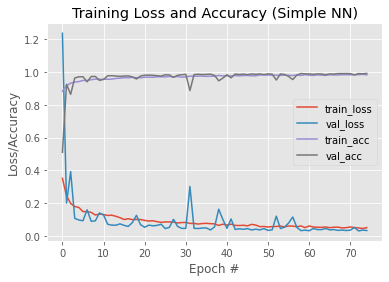

In [572]:
# plot the training loss and accuracy
N = np.arange(0, 75)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot")

## Getting ROI

In [652]:
image=cv2.imread("masks2.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [653]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=3,
        minSize=(30, 30)
)

for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    
print("Found {0} Faces!".format(len(faces)))

Found 4 Faces!


Text(0.5, 1.0, 'Face Detection')

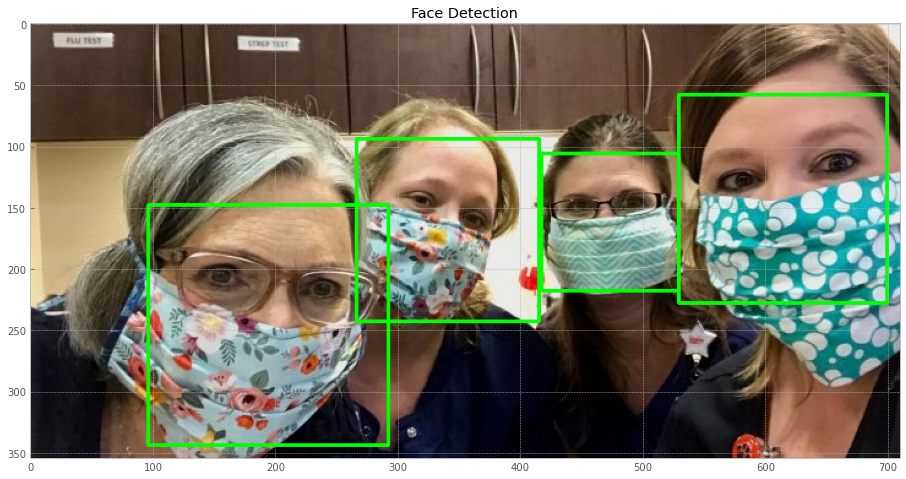

In [654]:
fig, axes = plt.subplots(ncols=1, figsize=(16, 8))
axes.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
axes.set_title('Face Detection')

# Running pictures through Model

In [655]:
new_model = tf.keras.models.load_model('Model2')

[[1.000000e+00 2.422768e-11]]
[[1.0000000e+00 1.8614249e-14]]
[[9.999944e-01 5.649965e-06]]
[[9.9999833e-01 1.6958530e-06]]


Text(0.5, 1.0, 'Face Detection')

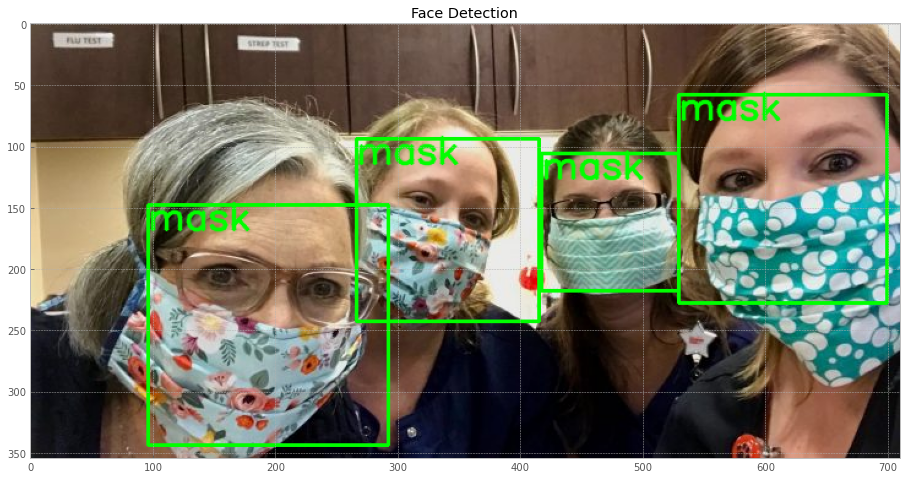

In [656]:
#extract images into separate variables
newImage = image.copy()
for x,y,w,h in faces:
    color = (0,0,0)
    face = image[y:y+h+50, x:x+w+50]
    
    if face.shape[0] >= 100 and face.shape[1] >= 100:
        face = cv2.resize(face, (64, 64))
        face = face / 255
        face = np.expand_dims(face, axis=0)
        face = face.reshape((1, 64, 64, 3))
        pred = np.argmax(new_model.predict(face))
        classification = "mask"
        color = (0, 255, 0)
        print(new_model.predict(face))
        if pred == 1:
            classification = "no_mask"
            color = (0,0,255)

        cv2.rectangle(newImage, (x,y), (x+w, y+h), color, 2)
        cv2.putText(newImage, classification, (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    
plt.style.use("bmh")
fig, axes = plt.subplots(ncols=1, figsize=(16, 8))
axes.imshow(cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
axes.set_title('Face Detection')

In [657]:
def placeBoxes(image, model):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=4,
        minSize=(30, 30)
    )
    
    newImage = image.copy()
    for x,y,w,h in faces:
        color = (0,0,0)
        face = image[y:y+h+50, x:x+w+50]
    
        if face.shape[0] >= 100 and face.shape[1] >= 100:
            face = cv2.resize(face, (64, 64))
            face = face / 255
            face = np.expand_dims(face, axis=0)
            face = face.reshape((1, 64, 64, 3))
            pred = np.argmax(new_model.predict(face))
            classification = "mask"
            color = (0, 255, 0)
            print(new_model.predict(face))
            if pred == 1:
                classification = "no_mask"
                color = (0,0,255)

            cv2.rectangle(newImage, (x-50,y-50), (x+w+50, y+h+50), color, 5)
            cv2.putText(newImage, classification, (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

    plt.style.use("bmh")
    fig, axes = plt.subplots(ncols=1, figsize=(16, 8))
    axes.imshow(cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
    axes.set_title('Face Detection')
    
    return newImage

In [668]:
import time


hello
[[3.010945e-04 9.996989e-01]]
[[1.0000000e+00 2.9246898e-12]]
0.5226023197174072


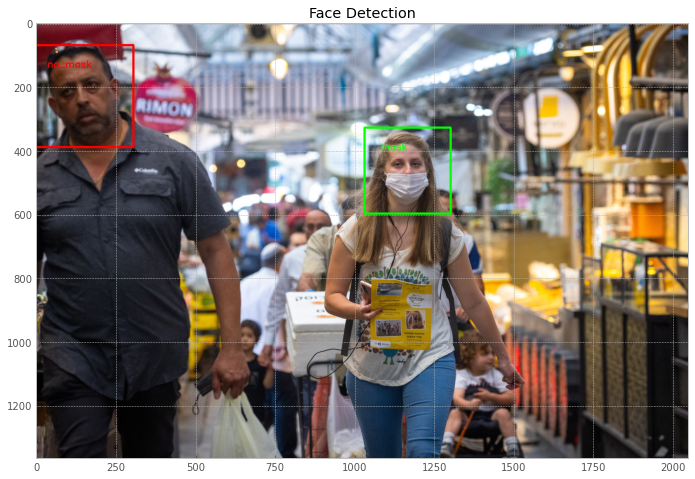

In [673]:
start = time.time()
print("hello")

newImage = placeBoxes(cv2.imread("mask3.jpeg"), model2)

end = time.time()
print(end - start)